In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('twitter_stock.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.asfreq('B') 

df.replace(0, np.nan, inplace=True)
df = df.interpolate(method='time').ffill().bfill()

df['MA10'] = df['Adj Close'].rolling(window=10).mean()
df['MA50'] = df['Adj Close'].rolling(window=50).mean()
# Simple RSI implementation
delta = df['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
df['RSI'] = 100 - (100 / (1 + gain/loss))
df.bfill(inplace=True)
target = 'Adj Close'
data = df[['Adj Close']]
train_size = int(len(data) * 0.9)
train, test = df[:train_size], df[train_size:]

print(f"Total samples: {len(data)} | Train: {len(train)} | Test: {len(test)}")

Total samples: 2346 | Train: 2111 | Test: 235


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.4f}")
    return rmse, mape, r2

In [3]:
def get_metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)
    print(f"[{name}] RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")
    return rmse, mape, r2

[Linear Regression] RMSE: 0.44, MAPE: 0.80%, R2: 0.9931


Text(0.5, 1.0, 'Linear Regression')

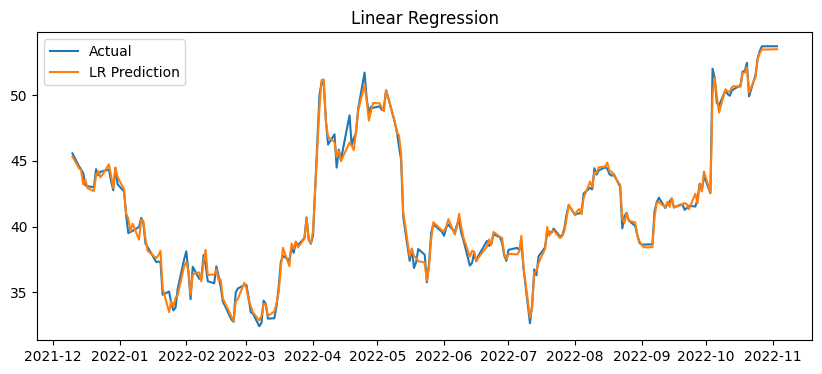

In [4]:
from sklearn.linear_model import LinearRegression

features = ['Open', 'High', 'Low', 'Volume', 'MA10', 'MA50', 'RSI']
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_results = get_metrics(y_test, lr_preds, "Linear Regression")

plt.figure(figsize=(10, 4))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, lr_preds, label='LR Prediction')
plt.legend()
plt.title("Linear Regression")

Random Forest Metrics:
RMSE: 1.5557
MAPE: 2.44%
R2 Score: 0.9147


Text(0.5, 1.0, 'Random Forest')

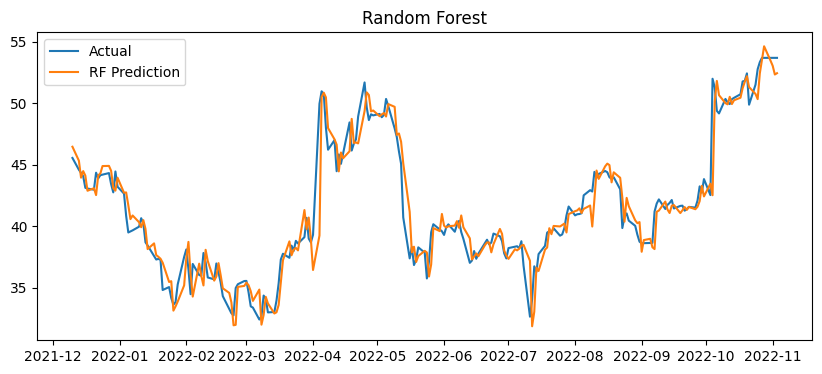

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Use windowed features (Past 5 days to predict today)
def create_features(df, window=5):
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df.iloc[i-window:i].values.flatten())
        y.append(df.iloc[i])
    return np.array(X), np.array(y)

X_rf, y_rf = create_features(data)
X_train_rf, X_test_rf = X_rf[:train_size-5], X_rf[train_size-5:]
y_train_rf, y_test_rf = y_rf[:train_size-5], y_rf[train_size-5:]

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_rf, y_train_rf.ravel())
rf_preds = rf_model.predict(X_test_rf)

print("Random Forest Metrics:")
rf_metrics = evaluate_model(y_test_rf, rf_preds)

plt.figure(figsize=(10, 4))
plt.plot(test.index, y_test_rf, label='Actual')
plt.plot(test.index, rf_preds, label='RF Prediction')
plt.legend()
plt.title("Random Forest")


Optimized XGBoost Metrics:
[XGBoost] RMSE: 0.68, MAPE: 1.13%, R2: 0.9835


Text(0.5, 1.0, 'XGBoost')

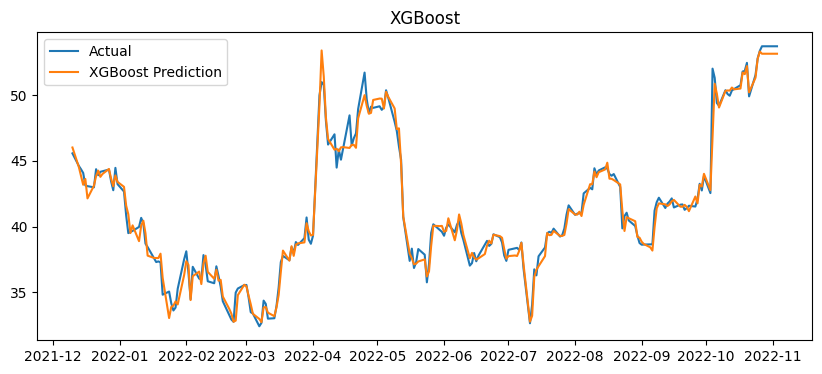

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1. Define the Parameter Grid
# We focus on the three most impactful parameters for stock prediction
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 2. Initialize the search
# We use TimeSeriesSplit instead of standard KFold to respect the chronological order
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    verbose=0,
    n_jobs=-1
)

# 3. Fit the search
grid_search.fit(X_train, y_train)

# 4. Extract and use the best model
best_xgb_model = grid_search.best_estimator_

# 5. Predict and Evaluate
xgb_preds = best_xgb_model.predict(X_test)
print("\nOptimized XGBoost Metrics:")
xgb_metrics = get_metrics(y_test, xgb_preds, "XGBoost")

plt.figure(figsize=(10, 4))
plt.plot(test.index, y_test_rf, label='Actual')
plt.plot(test.index, xgb_preds, label='XGBoost Prediction')
plt.legend()
plt.title("XGBoost")

Searching for the best ARIMA parameters...
Best ARIMA Order identified: (2, 1, 1)
Running ARIMA Walk-Forward Validation (This may take a minute)...

ARIMA Walk-Forward Metrics:
[ARIMA] RMSE: 1.46, MAPE: 2.19%, R2: 0.9247


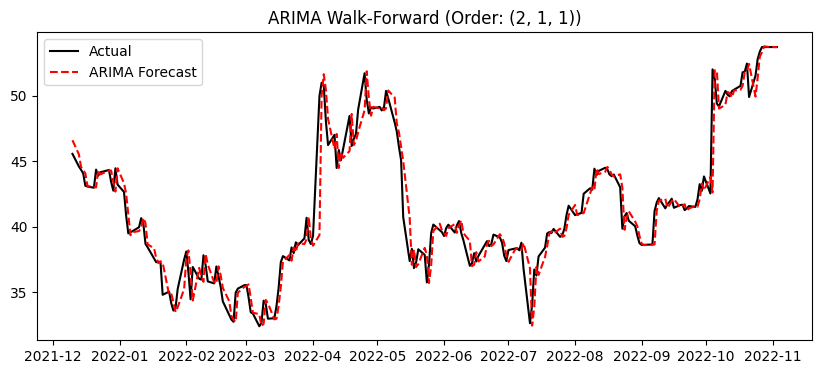

In [7]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# 1. PARAMETER SEARCH (Finds the 'best_model' parameters)
print("Searching for the best ARIMA parameters...")
# We use auto_arima to find the best p, d, q automatically
best_model_search = pm.auto_arima(
    train[target], 
    start_p=0, start_q=0,
    max_p=3, max_q=3,        
    d=None,                  
    seasonal=False,          
    stepwise=True,           
    suppress_warnings=True, 
    error_action="ignore", 
    trace=False
)

best_order = best_model_search.order
print(f"Best ARIMA Order identified: {best_order}")

# 2. WALK-FORWARD VALIDATION
history = [x for x in train[target]]
arima_preds = []

print("Running ARIMA Walk-Forward Validation (This may take a minute)...")

for t in range(len(test)):
    # Initialize and fit model using the order found above
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    
    # Predict the next day
    yhat = model_fit.forecast()[0]
    arima_preds.append(yhat)
    
    # Update history with the ACTUAL value to predict the next step
    actual = test[target].iloc[t]
    history.append(actual)

# 3. METRICS
print("\nARIMA Walk-Forward Metrics:")
arima_metrics = get_metrics(test[target], arima_preds, "ARIMA")

# 4. PLOT
plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual', color='black')
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Walk-Forward (Order: {best_order})")
plt.legend()
plt.show()

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

Starting LSTM optimization search (10 iterations)...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iteration 1: New best params found -> Units: 64, Dropout: 0.2, LR: 0.01
Iteration 2: New best params found -> Units: 128, Dropout: 0.2, LR: 0.01
Iteration 8: New best params found -> Units: 128, Dropout: 0.2, LR: 0.01
Finalizing best model training...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Optimized LSTM Metrics:
[LSTM] RMSE: 1.51, MAPE: 2.35%, R2: 0.9198


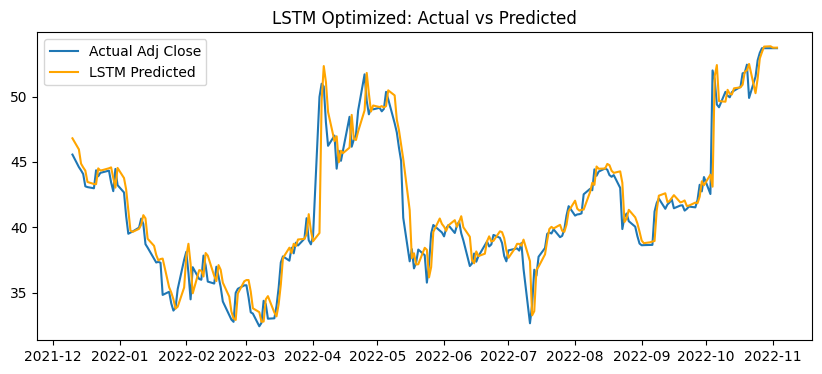

In [8]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import random

# 1. DATA SCALING
# LSTM is highly sensitive to the scale of input data.
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
# We fit the scaler only on the training data to prevent data leakage
train_idx = int(len(df) * 0.9)
scaled_data = lstm_scaler.fit_transform(df[[target]].values)

# 2. SEQUENCE CREATION FUNCTION
# seq_len defines how many previous days the model looks at to predict the next day
def create_lstm_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 60 

# To predict the first day of the test set, we need the 60 days prior to it.
# Therefore, test_scaled starts 60 days before the train/test split point.
train_scaled = scaled_data[:train_idx]
test_scaled = scaled_data[train_idx - seq_len:]

X_train_lstm, y_train_lstm = create_lstm_sequences(train_scaled, seq_len)
X_test_lstm, y_test_lstm_actual = create_lstm_sequences(test_scaled, seq_len)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# 3. DEFINE MODEL ARCHITECTURE & SEARCH
def build_optimized_lstm(units, dropout_rate, lr):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(dropout_rate),
        LSTM(units=int(units/2), return_sequences=False),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Hyperparameter Search Space
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2],
    'lr': [0.001, 0.01]
}

best_val_loss = float('inf')
best_lstm_model = None
iterations = 10 # Increase for a more thorough search

print(f"Starting LSTM optimization search ({iterations} iterations)...")

for i in range(iterations):
    u = random.choice(param_grid['units'])
    d = random.choice(param_grid['dropout'])
    l = random.choice(param_grid['lr'])
    
    current_model = build_optimized_lstm(u, d, l)
    # Use 10% of the training data as a validation set to find the best params
    history = current_model.fit(X_train_lstm, y_train_lstm, 
                                validation_split=0.1, 
                                epochs=10, batch_size=32, verbose=0)
    
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lstm_model = current_model
        print(f"Iteration {i+1}: New best params found -> Units: {u}, Dropout: {d}, LR: {l}")

# 4. FINAL TRAINING & PREDICTION
print("Finalizing best model training...")
best_lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)

# Get predictions and reverse the scaling to get actual prices
lstm_preds_scaled = best_lstm_model.predict(X_test_lstm)
lstm_preds = lstm_scaler.inverse_transform(lstm_preds_scaled)

# 5. METRICS & PLOT
print("\nOptimized LSTM Metrics:")
lstm_metrics = get_metrics(test[target].values, lstm_preds.flatten(), "LSTM")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target].values, label='Actual Adj Close')
plt.plot(test.index, lstm_preds.flatten(), label='LSTM Predicted', color='orange')
plt.title("LSTM Optimized: Actual vs Predicted")
plt.legend()
plt.show()

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:32:00 - cmdstanpy - INFO - Chain [1] start processing
22:32:00 - cmdstanpy - INFO - Chain [1] done processing



Prophet Conservative Metrics:
[Prophet] RMSE: 37.10, MAPE: 90.56%, R2: -47.5268


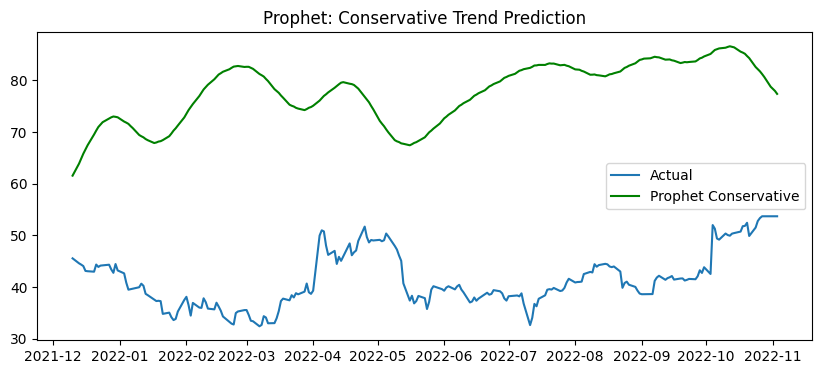

In [9]:
from prophet import Prophet

# 1. Prepare Data
prophet_df = train.reset_index()[['Date', target, 'Volume']].rename(columns={'Date': 'ds', target: 'y'})

# 2. Configure with Dampened Trend and Extra Regressor
m = Prophet(
    changepoint_prior_scale=0.005, # More conservative trend
    seasonality_mode='multiplicative', # Often better for financial series
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Add Volume as an extra hint for the model
m.add_regressor('Volume')

# 3. Fit
m.fit(prophet_df)

# 4. Predict
# Note: In a recursive setup, you'd feed the 'future' Volume one day at a time
future = m.make_future_dataframe(periods=len(test), freq='B')
# Merging actual test volume to allow the regressor to work (Walk-Forward logic)
future = future.merge(df[['Volume']].reset_index().rename(columns={'Date':'ds'}), on='ds', how='left')

forecast = m.predict(future)
prophet_preds = forecast['yhat'].iloc[-len(test):].values

# 5. Evaluation
print("\nProphet Conservative Metrics:")
prophet_metrics = get_metrics(test[target].values, prophet_preds, "Prophet")

# 6. Visualization
plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target].values, label='Actual')
plt.plot(test.index, prophet_preds, label='Prophet Conservative', color='green')
plt.title("Prophet: Conservative Trend Prediction")
plt.legend()
plt.show()

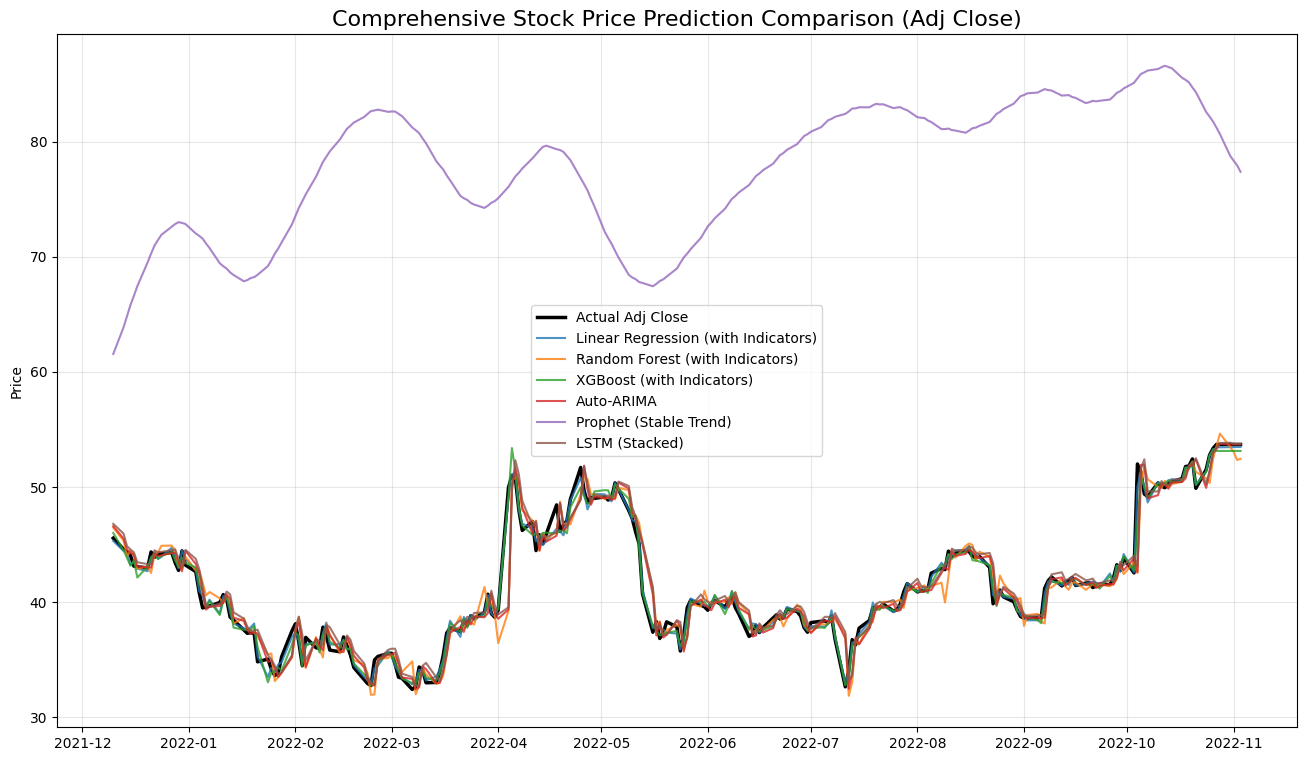

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(test.index, test[target], label='Actual Adj Close', color='black', linewidth=2.5)
plt.plot(test.index, lr_preds, label='Linear Regression (with Indicators)', alpha=0.8)
plt.plot(test.index, rf_preds, label='Random Forest (with Indicators)', alpha=0.8)
plt.plot(test.index, xgb_preds, label='XGBoost (with Indicators)', alpha=0.8)
plt.plot(test.index, arima_preds, label='Auto-ARIMA', alpha=0.8)
plt.plot(test.index, prophet_preds, label='Prophet (Stable Trend)', alpha=0.8)
plt.plot(test.index, lstm_preds, label='LSTM (Stacked)', alpha=0.8)

plt.title(f'Comprehensive Stock Price Prediction Comparison ({target})', fontsize=16)
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

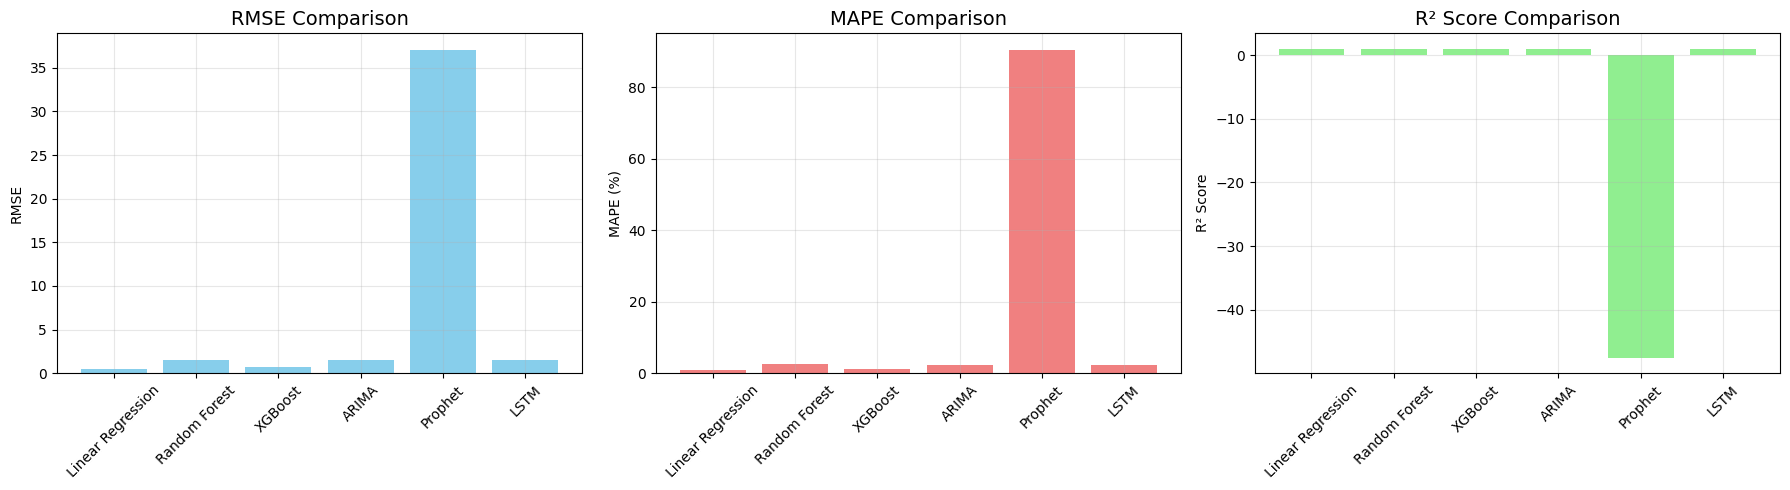

In [11]:
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'ARIMA', 'Prophet', 'LSTM']
rmse_values = [lr_results[0], rf_metrics[0], xgb_metrics[0], arima_metrics[0], prophet_metrics[0], lstm_metrics[0]]
mape_values = [lr_results[1], rf_metrics[1], xgb_metrics[1], arima_metrics[1], prophet_metrics[1], lstm_metrics[1]]
r2_values = [lr_results[2], rf_metrics[2], xgb_metrics[2], arima_metrics[2], prophet_metrics[2], lstm_metrics[2]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(models, rmse_values, color='skyblue')
axes[0].set_title('RMSE Comparison', fontsize=14)
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(models, mape_values, color='lightcoral')
axes[1].set_title('MAPE Comparison', fontsize=14)
axes[1].set_ylabel('MAPE (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].bar(models, r2_values, color='lightgreen')
axes[2].set_title('R² Score Comparison', fontsize=14)
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()